In [61]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns  # makes heatmap look better

def create_mask(seq):
    seq_len = seq.size(1)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        self.self_attn1 = SelfAttention(d_model)
        self.feed_forward1 = nn.Sequential(
            nn.Linear(d_model, 4*d_model), # expanding and contracting the model for it to learn more intricate patterns
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model)
        )

        self.self_attn2 = SelfAttention(d_model)
        self.feed_forward2 = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model)
        )

        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, input):
        input = self.embedding(input)
        input = self.pos_encoder(input)

        mask = create_mask(input).to(input.device)
        
        attn1_output, attn_weights1 = self.self_attn1(input, input, input, mask)

        # actually doing residual connection here by attn1_output + input
        ff1_output = self.feed_forward1(attn1_output) + input
        
        attn2_output, attn_weights2 = self.self_attn2(ff1_output, ff1_output, ff1_output, mask)
        ff2_output = self.feed_forward2(attn2_output) + ff1_output

        attn_weights1 = attn_weights1.cpu().detach().numpy()

        logits = self.fc(ff2_output)
        return logits, attn_weights1, attn_weights2

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)

    def forward(self, query, key, value, mask=None):
        q = self.query(query)
        k = self.key(key)
        v = self.value(value)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_model)

        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
            
        attention_weights = torch.nn.functional.softmax(scores, dim=-1)

        output = torch.matmul(attention_weights, v)
        return output, attention_weights

def plot_attention(attention, source_seq, target_seq):
    """
    Plots the attention weights.
    :param attention: Attention weights matrix.
    :param source_seq: Source sequence tokens.
    :param target_seq: Target sequence tokens.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(attention, cmap='viridis', xticklabels=source_seq, yticklabels=target_seq)
    plt.xlabel('Keys (Source)')
    plt.ylabel('Queries (Target)')
    plt.show()

len(names) 4946
id_to_token {0: '<pad>', 1: '<eos>', 2: '<sos>', 3: ' ', 4: '-', 5: 'A', 6: 'B', 7: 'C', 8: 'D', 9: 'E', 10: 'F', 11: 'G', 12: 'H', 13: 'I', 14: 'J', 15: 'K', 16: 'L', 17: 'M', 18: 'N', 19: 'O', 20: 'P', 21: 'Q', 22: 'R', 23: 'S', 24: 'T', 25: 'U', 26: 'V', 27: 'W', 28: 'X', 29: 'Y', 30: 'Z', 31: 'a', 32: 'b', 33: 'c', 34: 'd', 35: 'e', 36: 'f', 37: 'g', 38: 'h', 39: 'i', 40: 'j', 41: 'k', 42: 'l', 43: 'm', 44: 'n', 45: 'o', 46: 'p', 47: 'q', 48: 'r', 49: 's', 50: 't', 51: 'u', 52: 'v', 53: 'w', 54: 'x', 55: 'y', 56: 'z'}
token_to_id {'<pad>': 0, '<eos>': 1, '<sos>': 2, ' ': 3, '-': 4, 'A': 5, 'B': 6, 'C': 7, 'D': 8, 'E': 9, 'F': 10, 'G': 11, 'H': 12, 'I': 13, 'J': 14, 'K': 15, 'L': 16, 'M': 17, 'N': 18, 'O': 19, 'P': 20, 'Q': 21, 'R': 22, 'S': 23, 'T': 24, 'U': 25, 'V': 26, 'W': 27, 'X': 28, 'Y': 29, 'Z': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 

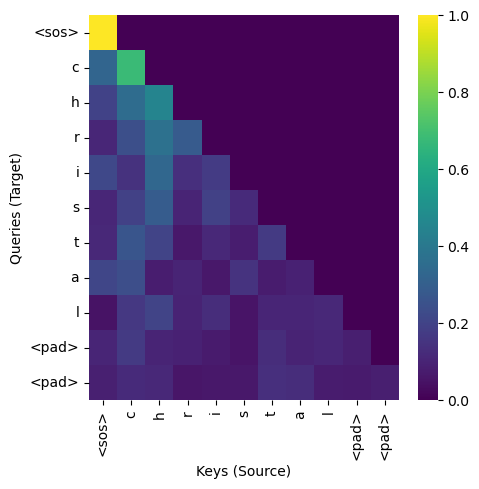

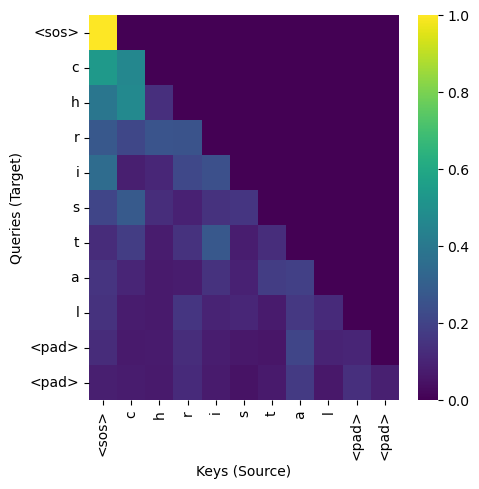

Epoch 1/50 - Loss: 2.5646
Epoch 2/50 - Loss: 2.2522
Epoch 3/50 - Loss: 2.1826
Epoch 4/50 - Loss: 2.1467
Epoch 5/50 - Loss: 2.1175
Epoch 6/50 - Loss: 2.0925
Epoch 7/50 - Loss: 2.0704
Epoch 8/50 - Loss: 2.0530
Epoch 9/50 - Loss: 2.0368
Epoch 10/50 - Loss: 2.0214
Epoch 11/50 - Loss: 2.0097
Epoch 12/50 - Loss: 1.9959
Epoch 13/50 - Loss: 1.9798
Epoch 14/50 - Loss: 1.9729
Epoch 15/50 - Loss: 1.9605
Epoch 16/50 - Loss: 1.9522
Epoch 17/50 - Loss: 1.9362
Epoch 18/50 - Loss: 1.9293
Epoch 19/50 - Loss: 1.9193
Epoch 20/50 - Loss: 1.9092
Epoch 21/50 - Loss: 1.9040
Epoch 22/50 - Loss: 1.8930
Epoch 23/50 - Loss: 1.8851
Epoch 24/50 - Loss: 1.8775
Epoch 25/50 - Loss: 1.8756
Epoch 26/50 - Loss: 1.8623
Epoch 27/50 - Loss: 1.8580
Epoch 28/50 - Loss: 1.8462
Epoch 29/50 - Loss: 1.8380
Epoch 30/50 - Loss: 1.8351
Epoch 31/50 - Loss: 1.8304
Epoch 32/50 - Loss: 1.8182
Epoch 33/50 - Loss: 1.8182
Epoch 34/50 - Loss: 1.8112
Epoch 35/50 - Loss: 1.8063
Epoch 36/50 - Loss: 1.7970
Epoch 37/50 - Loss: 1.7959
Epoch 38/5

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from collections import Counter
import json
import sentencepiece as spm

with open('./first-names.json', 'r') as file:
    names = json.load(file)

print('len(names)',len(names))

# Create a simple tokenizer
def tokenize_names(names):
    # Convert names into a single string
    text = " ".join(names)
    # Tokenize by characters
    tokens = list(text)
    # Build vocab
    vocab = ['<pad>', '<eos>', '<sos>'] + sorted(set(tokens))
    token_to_id = {token: id for id, token in enumerate(vocab)}
    id_to_token = {id: token for id, token in enumerate(vocab)}
    return token_to_id, id_to_token, vocab


token_to_id, id_to_token, vocab = tokenize_names(names)
vocab_size = len(vocab)
print('id_to_token', id_to_token)
print('token_to_id', token_to_id)

def target_name_to_tensor(name):
    tokens = list(name.lower())
    return torch.tensor([token_to_id[t] for t in tokens + ['<eos>']])

def input_name_to_tensor(name):
    tokens = list(name.lower())
    return torch.tensor([token_to_id[t] for t in ['<sos>'] + tokens])

class NameDataset(Dataset):
    def __init__(self, names):
        self.names = names
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        name = self.names[idx]
        return input_name_to_tensor(name), target_name_to_tensor(name)

def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=token_to_id['<pad>'])
    targets = pad_sequence(targets, batch_first=True, padding_value=token_to_id['<pad>'])
    return inputs, targets

# Create dataset and dataloader
batch_size = 20
dataset = NameDataset(names)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Define the model, optimizer, and loss
vocab_size = len(vocab)
d_model = 256
decoder = TransformerDecoder(vocab_size, d_model)
optimizer = Adam(decoder.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 50

PAD_TOKEN = token_to_id['<pad>']

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

decoder.train()
first_iteration = True

for epoch in range(num_epochs):
    total_loss = 0.0

    for inputs, targets in dataloader:
        optimizer.zero_grad()

        outputs, final_attn_weights1, final_attn_weights2 = decoder(inputs)

        if first_iteration == True:
            # # Convert token IDs to string for better visualization (assuming a dictionary of id_to_token)
            source_seq = [id_to_token[id.item()] for id in inputs[0]]  # Taking the first sequence in the batch
            print('final_attn_weights1', final_attn_weights1.shape)
            print('final_attn_weights2', final_attn_weights2.shape)
            plot_attention(final_attn_weights1[0], source_seq, source_seq)

            plot_attention(final_attn_weights2[0].detach(), source_seq, source_seq)
        
            tensor_as_strings_inputs = [[id_to_token[id.item()] for id in row] for row in inputs]
            tensor_as_strings_targets = [[id_to_token[id.item()] for id in row] for row in targets]

            # print('inputs,', inputs)
            # print('targets,', targets)
            # print('tensor_as_strings_inputs,', tensor_as_strings_inputs)
            # print('tensor_as_strings_targets,', tensor_as_strings_targets)
            # print('outputs', outputs.shape)
            # print('targets', targets.shape)
            # print('outputs.view(-1, vocab_size)', outputs.view(-1, vocab_size))
            # print('outputs.view(-1, vocab_size).shape', outputs.view(-1, vocab_size).shape)
            # print('targets.view',targets.view(-1))
            first_iteration = False

            # print('outputs.view(-1, vocab_size)', outputs.view(-1, vocab_size))
            # print('targets.view(-1)', targets.view(-1))
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}")




Here we use a greedy approach where we always take the highest probable tokens from the softmax output. As you can see we always produce the same name here

In [73]:

print('vocab_size', vocab_size)
def generate_name(model, max_length=15):
    model.eval()
    with torch.no_grad():
        print(token_to_id)
        input_token = token_to_id['<sos>']
        output_sequence = [input_token] # we'll always get the same name because we are using the same model and the same starter token

        for i in range(max_length):
            input_tensor = torch.tensor([output_sequence]).long()
            logit_output, _, _ = model(input_tensor)

            softmax = nn.Softmax(dim=-1)
            softmax_output = softmax(logit_output)
            # Taking the token with the highest probability for prediction

            predicted_token = softmax_output[0, -1, :].argmax().item()

            # Break if we predict the end-of-string token
            if predicted_token == token_to_id['<eos>']:
                break

            output_sequence.append(predicted_token)
        

        # Convert token IDs back to strings
        print(output_sequence[1:])
        print('id_to_token', id_to_token)
        generated_name = ''.join([id_to_token.get(token_id, '<UNK>') for token_id in output_sequence[1:]])

    return generated_name

generated_name = generate_name(decoder)
print(generated_name)

vocab_size 57
{'<pad>': 0, '<eos>': 1, '<sos>': 2, ' ': 3, '-': 4, 'A': 5, 'B': 6, 'C': 7, 'D': 8, 'E': 9, 'F': 10, 'G': 11, 'H': 12, 'I': 13, 'J': 14, 'K': 15, 'L': 16, 'M': 17, 'N': 18, 'O': 19, 'P': 20, 'Q': 21, 'R': 22, 'S': 23, 'T': 24, 'U': 25, 'V': 26, 'W': 27, 'X': 28, 'Y': 29, 'Z': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56}
[31, 44, 44, 31, 32, 35, 42]
id_to_token {0: '<pad>', 1: '<eos>', 2: '<sos>', 3: ' ', 4: '-', 5: 'A', 6: 'B', 7: 'C', 8: 'D', 9: 'E', 10: 'F', 11: 'G', 12: 'H', 13: 'I', 14: 'J', 15: 'K', 16: 'L', 17: 'M', 18: 'N', 19: 'O', 20: 'P', 21: 'Q', 22: 'R', 23: 'S', 24: 'T', 25: 'U', 26: 'V', 27: 'W', 28: 'X', 29: 'Y', 30: 'Z', 31: 'a', 32: 'b', 33: 'c', 34: 'd', 35: 'e', 36: 'f', 37: 'g', 38: 'h', 39: 'i', 40: 'j', 41: 'k', 42: 'l', 43: 'm', 44: 'n', 45: 'o', 46: 'p', 47:

Here we use Top-k sampling: At each step, sample from the top k probable tokens instead of the highest probable token approach where we always take the highest probable tokens from the softmax output. As you can see we consistently produce new names different from the names in the dataset

In [77]:
def top_k_sampling(logits, k=6):  
    # Obtain the top k logits
    values, indices = torch.topk(logits, k)
    # Create a distribution over the top k logits only
    distribution = torch.nn.functional.softmax(values, dim=-1)
    
    # Sample from the distribution
    choice = torch.multinomial(distribution, 1)
    # Choose the actual token from the top k
    token = indices.gather(-1, choice).squeeze().item()
    return token

def generate_name(model, max_length=15, k=10):  # added k parameter
    model.eval()
    with torch.no_grad():
        input_token = token_to_id['<sos>']
        output_sequence = [input_token]

        for i in range(max_length):
            input_tensor = torch.tensor([output_sequence]).long()
            logit_output, _, _ = model(input_tensor)

            # Use top_k_sampling instead of the greedy approach
            predicted_token = top_k_sampling(logit_output[0, -1, :], k)

            # Break if we predict the end-of-string token
            if predicted_token == token_to_id['<eos>']:
                break

            output_sequence.append(predicted_token)
        
        # Convert token IDs back to strings
        generated_name = ''.join([id_to_token.get(token_id, '<UNK>') for token_id in output_sequence[1:]])

    return generated_name

generated_name = generate_name(decoder)
print(generated_name)


lucilla


Here we use temperature sampling instead of top k sampling

In [84]:
def temperature_sampling(logits, temperature=1.0):
    # Divide the logits by the temperature
    logits = logits / temperature
    # Create a distribution
    distribution = torch.nn.functional.softmax(logits, dim=-1)
    # Sample from the distribution
    choice = torch.multinomial(distribution, 1)
    token = choice.squeeze().item()
    return token

def generate_name(model, max_length=15, temperature=1.0):  # added temperature parameter
    model.eval()
    with torch.no_grad():
        input_token = token_to_id['<sos>']
        output_sequence = [input_token]

        for i in range(max_length):
            input_tensor = torch.tensor([output_sequence]).long()
            logit_output, _, _ = model(input_tensor)

            # Use temperature_sampling instead of the greedy approach
            predicted_token = temperature_sampling(logit_output[0, -1, :], temperature)

            # Break if we predict the end-of-string token
            if predicted_token == token_to_id['<eos>']:
                break

            output_sequence.append(predicted_token)
        
        # Convert token IDs back to strings
        generated_name = ''.join([id_to_token.get(token_id, '<UNK>') for token_id in output_sequence[1:]])

    return generated_name

generated_name = generate_name(decoder, temperature=0.8)  # You can play around with different temperature values
print(generated_name)


dorea
